# Price Prediction

In [0]:
from xgboost import XGBRegressor
from xgboost import XGBClassifier, XGBRegressor
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
from pyspark.sql.functions import col, when
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from catboost import CatBoostRegressor, CatBoostClassifier

In [0]:


spark.sql("USE energy_analytics")

df = spark.table("silver_energy_melbourne_extended") \
    .filter(col("scheduled_generation").isNotNull()) \
    .filter(col("avg_temp").isNotNull()) \
    .select(
        col("datetime_aest"),
        col("hour_of_day"),
        col("day_of_week"),
        col("month"),
        col("price"),
        col("price_max"),
        col("price_min"),
        col("demand_mw"),
        col("renewable_pct"),
        col("coal"),
        col("gas"),
        col("hydro"),
        col("wind"),
        col("solar"),
        col("total_generation"),
        col("semischeduled_generation"),
        col("avg_temp"),
        col("avg_humidity"),
        col("avg_wind_speed"),
        col("solar_radiation"),
        col("cloud_cover"),
        when(col("is_peak") == 1.0, 1.0).otherwise(0.0).alias("is_peak")
    ) \
    .orderBy("datetime_aest")

df = df.toPandas().sort_values("datetime_aest").reset_index(drop=True)

print(f"Records : {len(df):,}")
print(f"From    : {df['datetime_aest'].min()}")
print(f"To      : {df['datetime_aest'].max()}")
print(f"Price   : ${df['price'].min():.2f} to ${df['price'].max():.2f}")

Records : 26,156
From    : 2023-03-01 00:00:00
To      : 2026-02-20 23:00:00
Price   : $-461.50 to $16600.00


In [0]:

f = df.copy()

f['hour_sin']  = np.sin(2 * np.pi * f['hour_of_day'] / 24)
f['hour_cos']  = np.cos(2 * np.pi * f['hour_of_day'] / 24)
f['dow_sin']   = np.sin(2 * np.pi * f['day_of_week'] / 7)
f['dow_cos']   = np.cos(2 * np.pi * f['day_of_week'] / 7)
f['month_sin'] = np.sin(2 * np.pi * f['month'] / 12)
f['month_cos'] = np.cos(2 * np.pi * f['month'] / 12)

f['price_range'] = f['price_max'] - f['price_min']

for col_name, shifts in [
    ('price',            [1, 2, 24, 168]),
    ('demand_mw',        [1, 24]),
    ('renewable_pct',    [1, 24]),
    ('avg_temp',         [1, 24]),
    ('solar_radiation',  [1, 24]),
    ('wind',             [1, 24]),
    ('solar',            [1, 24]),
    ('coal',             [1]),
    ('gas',              [1]),
    ('total_generation', [1]),
]:
    for s in shifts:
        f[f'{col_name}_lag{s}'] = f[col_name].shift(s)

for window in [4, 24]:
    f[f'price_roll{window}_mean']  = f['price'].shift(1).rolling(window).mean()
    f[f'price_roll{window}_std']   = f['price'].shift(1).rolling(window).std()
    f[f'demand_roll{window}_mean'] = f['demand_mw'].shift(1).rolling(window).mean()

f['temp_roll24_mean']  = f['avg_temp'].shift(1).rolling(24).mean()
f['solar_roll24_mean'] = f['solar_radiation'].shift(1).rolling(24).mean()

f['temp_x_demand']      = f['avg_temp']        * f['demand_mw']
f['renewable_x_demand'] = f['renewable_pct']   * f['demand_mw']
f['temp_x_peak']        = f['avg_temp']        * f['is_peak']
f['solar_x_cloud']      = f['solar_radiation'] * (1 - f['cloud_cover'] / 100)
f['demand_dev24']       = f['demand_mw']       - f['demand_roll24_mean']
f['price_momentum']     = f['price_lag1']      - f['price_lag24']

f = f.dropna().reset_index(drop=True)

price_features_list = [
    'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'month_sin', 'month_cos',
    'demand_mw', 'renewable_pct', 'avg_temp', 'avg_humidity', 'avg_wind_speed',
    'solar_radiation', 'cloud_cover', 'is_peak',
    'coal', 'gas', 'hydro', 'wind', 'solar',
    'total_generation', 'semischeduled_generation',
    'price_range',
    'price_lag1', 'price_lag2', 'price_lag24', 'price_lag168',
    'demand_mw_lag1', 'demand_mw_lag24',
    'renewable_pct_lag1', 'renewable_pct_lag24',
    'avg_temp_lag1', 'avg_temp_lag24',
    'solar_radiation_lag1', 'solar_radiation_lag24',
    'wind_lag1', 'wind_lag24', 'solar_lag1', 'solar_lag24',
    'coal_lag1', 'gas_lag1', 'total_generation_lag1',
    'price_roll4_mean', 'price_roll4_std',
    'price_roll24_mean', 'price_roll24_std',
    'demand_roll4_mean', 'demand_roll24_mean',
    'temp_roll24_mean', 'solar_roll24_mean',
    'temp_x_demand', 'renewable_x_demand', 'temp_x_peak', 'solar_x_cloud',
    'demand_dev24', 'price_momentum',
]

f_price = f.copy()
X_price = f_price[price_features_list]
y_price = f_price['price']

print(f"Price features : {len(price_features_list)}")
print(f"Samples        : {len(X_price):,}")

Price features : 55
Samples        : 25,988


In [0]:

split_idx = int(len(X_price) * 0.8)
X_train, X_test = X_price.iloc[:split_idx], X_price.iloc[split_idx:]
y_train, y_test = y_price.iloc[:split_idx], y_price.iloc[split_idx:]

shift = abs(y_train.min()) + 1
y_train_log = np.log1p(y_train + shift)

model_price = XGBRegressor(
    n_estimators=457,
    max_depth=11,
    min_child_weight=0.631,
    learning_rate=0.0259,
    subsample=0.841,
    colsample_bylevel=0.359,
    colsample_bytree=0.627,
    reg_alpha=0.00561,
    reg_lambda=2.030,
    tree_method="hist",
    random_state=42,
    n_jobs=-1
)

model_price.fit(X_train, y_train_log)

y_pred_log = model_price.predict(X_test)
y_pred     = np.expm1(y_pred_log) - shift

mae  = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2   = r2_score(y_test, y_pred)
mask = np.abs(y_test) >= 5
mape = np.mean(np.abs((y_test[mask] - y_pred[mask]) / y_test[mask])) * 100

print(f"MAE  : ${mae:.2f}/MWh")
print(f"RMSE : ${rmse:.2f}/MWh")
print(f"R²   : {r2:.4f}")
print(f"MAPE : {mape:.1f}%")
print(f"PRICE_SHIFT = {shift:.4f}")

MAE  : $14.90/MWh
RMSE : $25.08/MWh
R²   : 0.8876
MAPE : 49.7%
PRICE_SHIFT = 462.5025


/home/spark-372ab003-9a35-47f8-90f1-fa/.ipykernel/3715/command-5778793631701871-401560558:58: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('tier')['residual'].mean()


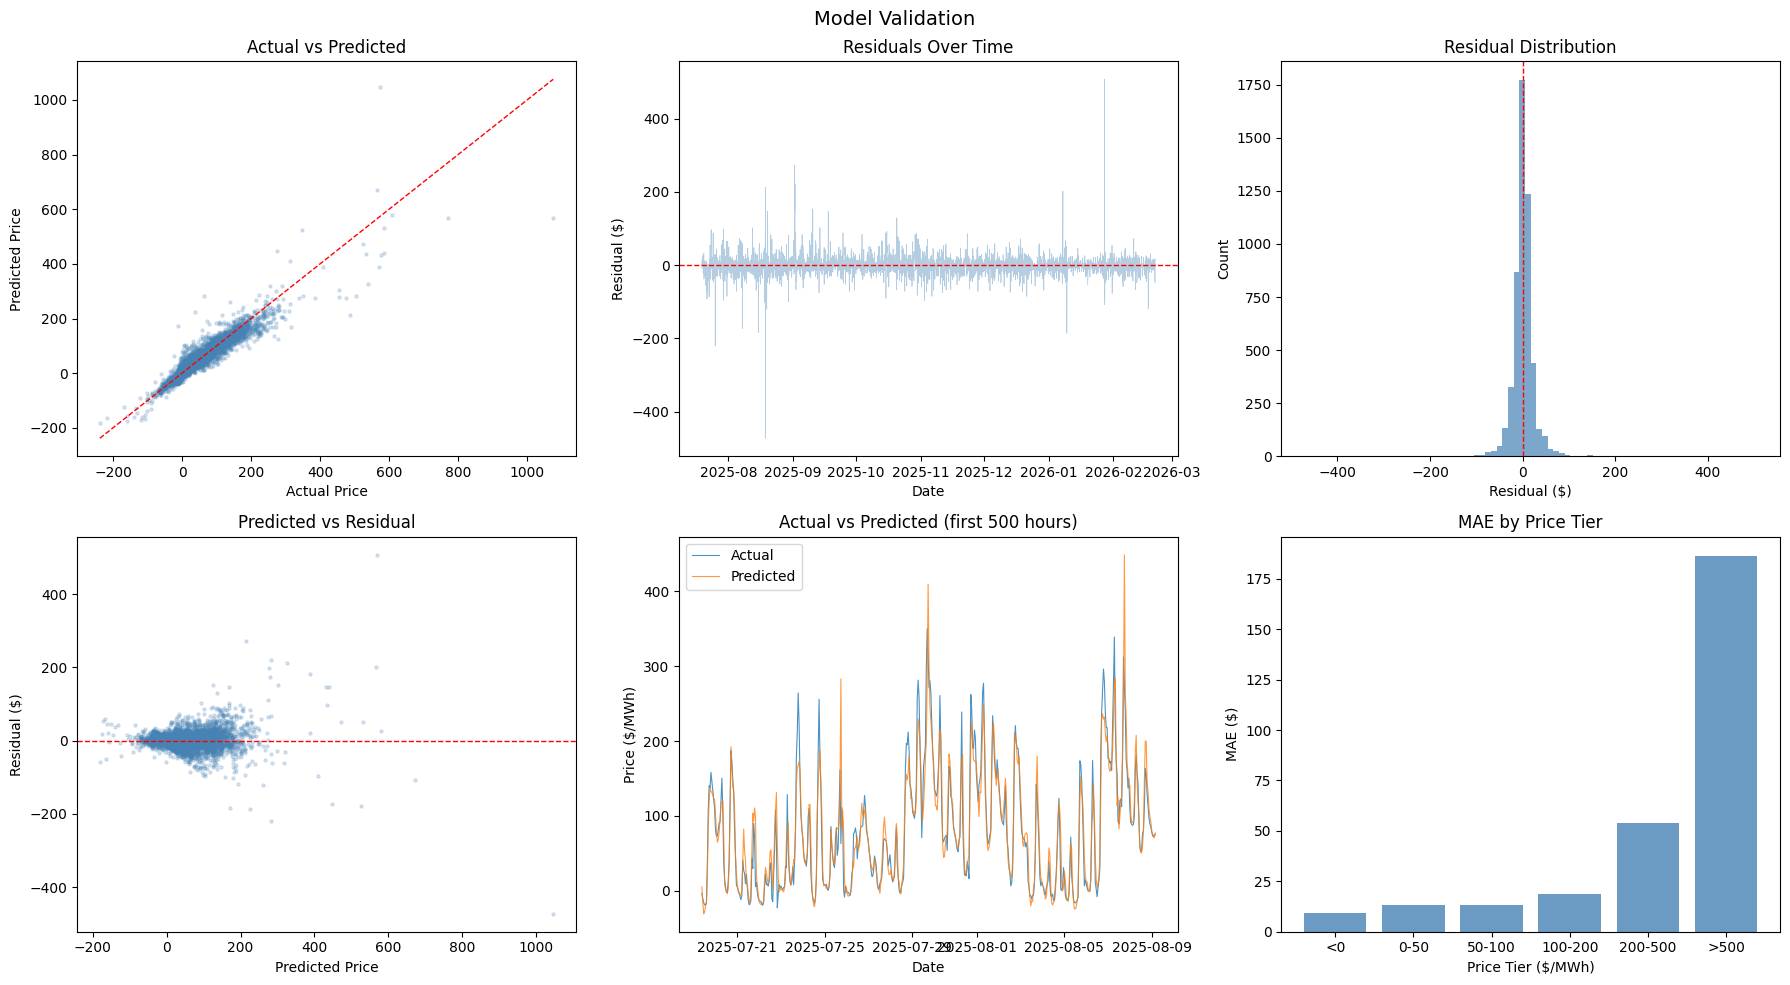

In [0]:


test_dates = f['datetime_aest'].iloc[split_idx:].values
residuals  = y_test.values - y_pred

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Model Validation', fontsize=14)


ax = axes[0, 0]
ax.scatter(y_test, y_pred, alpha=0.2, s=5, color='steelblue')
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
ax.plot(lims, lims, 'r--', linewidth=1)
ax.set_xlabel('Actual Price')
ax.set_ylabel('Predicted Price')
ax.set_title('Actual vs Predicted')


ax = axes[0, 1]
ax.plot(test_dates, residuals, alpha=0.4, linewidth=0.5, color='steelblue')
ax.axhline(0, color='red', linestyle='--', linewidth=1)
ax.set_xlabel('Date')
ax.set_ylabel('Residual ($)')
ax.set_title('Residuals Over Time')


ax = axes[0, 2]
ax.hist(residuals, bins=80, color='steelblue', alpha=0.7, edgecolor='none')
ax.axvline(0, color='red', linestyle='--', linewidth=1)
ax.set_xlabel('Residual ($)')
ax.set_ylabel('Count')
ax.set_title('Residual Distribution')


ax = axes[1, 0]
ax.scatter(y_pred, residuals, alpha=0.2, s=5, color='steelblue')
ax.axhline(0, color='red', linestyle='--', linewidth=1)
ax.set_xlabel('Predicted Price')
ax.set_ylabel('Residual ($)')
ax.set_title('Predicted vs Residual')


ax = axes[1, 1]
n = min(500, len(test_dates))
ax.plot(test_dates[:n], y_test.values[:n], label='Actual', linewidth=0.8, alpha=0.8)
ax.plot(test_dates[:n], y_pred[:n],        label='Predicted', linewidth=0.8, alpha=0.8)
ax.set_xlabel('Date')
ax.set_ylabel('Price ($/MWh)')
ax.set_title('Actual vs Predicted (first 500 hours)')
ax.legend()


ax = axes[1, 2]
bins   = [-500, 0, 50, 100, 200, 500, 17000]
labels = ['<0', '0-50', '50-100', '100-200', '200-500', '>500']
tiers  = pd.cut(y_test, bins=bins, labels=labels)
mae_by_tier = pd.DataFrame({'residual': np.abs(residuals), 'tier': tiers}) \
                .groupby('tier')['residual'].mean()
ax.bar(mae_by_tier.index, mae_by_tier.values, color='steelblue', alpha=0.8)
ax.set_xlabel('Price Tier ($/MWh)')
ax.set_ylabel('MAE ($)')
ax.set_title('MAE by Price Tier')

plt.tight_layout()
plt.show()

# Demand Forecasting

In [0]:




spark.sql("USE energy_analytics")

df = spark.table("silver_energy_melbourne_extended") \
    .filter(col("avg_temp").isNotNull()) \
    .select(
        col("datetime_aest"),
        col("hour_of_day"),
        col("day_of_week"),
        col("month"),
        col("demand_mw"),
        col("avg_temp"),
        col("avg_humidity"),
        col("avg_wind_speed"),
        col("solar_radiation"),
        col("cloud_cover"),
        col("renewable_pct"),
        col("coal"),
        col("gas"),
        col("wind"),
        col("solar"),
        col("total_generation"),
        col("semischeduled_generation"),
        when(col("is_peak") == 1.0, 1.0).otherwise(0.0).alias("is_peak")
    ) \
    .orderBy("datetime_aest")

df = df.toPandas().sort_values("datetime_aest").reset_index(drop=True)

print(f"Records : {len(df):,}")
print(f"From    : {df['datetime_aest'].min()}")
print(f"To      : {df['datetime_aest'].max()}")
print(f"Demand  : {df['demand_mw'].min():.0f} to {df['demand_mw'].max():.0f} MW")

Records : 26,160
From    : 2023-03-01 00:00:00
To      : 2026-02-20 23:00:00
Demand  : 1276 to 10506 MW


In [0]:
f = df.copy()

f['hour_sin']  = np.sin(2 * np.pi * f['hour_of_day'] / 24)
f['hour_cos']  = np.cos(2 * np.pi * f['hour_of_day'] / 24)
f['month_cos'] = np.cos(2 * np.pi * f['month'] / 12)

for col_name, shifts in [
    ('demand_mw',       [1, 2, 24, 48, 168]),
    ('avg_temp',        [1, 24]),
    ('solar_radiation', [1, 24]),
    ('wind',            [1, 24]),
    ('renewable_pct',   [1, 24]),
]:
    for s in shifts:
        f[f'{col_name}_lag{s}'] = f[col_name].shift(s)

for window in [4, 24]:
    f[f'demand_roll{window}_mean'] = f['demand_mw'].shift(1).rolling(window).mean()
    f[f'demand_roll{window}_std']  = f['demand_mw'].shift(1).rolling(window).std()
    f[f'temp_roll{window}_mean']   = f['avg_temp'].shift(1).rolling(window).mean()

f['solar_roll24_mean']  = f['solar_radiation'].shift(1).rolling(24).mean()
f['temp_x_peak']        = f['avg_temp']        * f['is_peak']
f['temp_x_demand_lag1'] = f['avg_temp']        * f['demand_mw_lag1']
f['solar_x_cloud']      = f['solar_radiation'] * (1 - f['cloud_cover'] / 100)
f['demand_momentum']    = f['demand_mw_lag1']  - f['demand_mw_lag24']

f = f.dropna().reset_index(drop=True)

demand_features_list = [
    'hour_sin', 'hour_cos', 'month_cos',
    'demand_mw_lag1', 'demand_mw_lag2', 'demand_mw_lag24',
    'demand_mw_lag48', 'demand_mw_lag168',
    'demand_roll4_mean', 'demand_roll24_mean',
    'demand_momentum', 'temp_x_demand_lag1',
    'solar_radiation_lag1', 'is_peak', 'solar_x_cloud',
]

f_demand = f.copy()
X_demand = f_demand[demand_features_list]
y_demand = f_demand['demand_mw']

print(f"Demand features : {len(demand_features_list)}")
print(f"Samples         : {len(X_demand):,}")

Demand features : 15
Samples         : 25,980


In [0]:



split_idx = int(len(X_demand) * 0.8)
X_train, X_test = X_demand.iloc[:split_idx], X_demand.iloc[split_idx:]
y_train, y_test = y_demand.iloc[:split_idx], y_demand.iloc[split_idx:]



model_demand = CatBoostRegressor(
    n_estimators=8192,
    learning_rate=0.0413,
    depth=6,
    l2_leaf_reg=5.0,
    early_stopping_rounds=21,
    random_seed=42,
    verbose=0
)


model_demand.fit(X_train, y_train, eval_set=(X_test, y_test))

y_pred       = model_demand.predict(X_test)
y_train_pred = model_demand.predict(X_train)

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae  = mean_absolute_error(y_test, y_pred)
train_r2  = r2_score(y_train, y_train_pred)
test_r2   = r2_score(y_test, y_pred)
mape      = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
residuals = y_test.values - y_pred

print(f"           Train     Test")
print(f"MAE      : {train_mae:.0f} MW     {test_mae:.0f} MW")
print(f"R²       : {train_r2:.4f}    {test_r2:.4f}")
print(f"MAPE     : {mape:.1f}%")

           Train     Test
MAE      : 68 MW     112 MW
R²       : 0.9927    0.9803
MAPE     : 2.5%


/home/spark-372ab003-9a35-47f8-90f1-fa/.ipykernel/3715/command-7282864781100534-1498194755:55: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('tier')['residual'].mean()


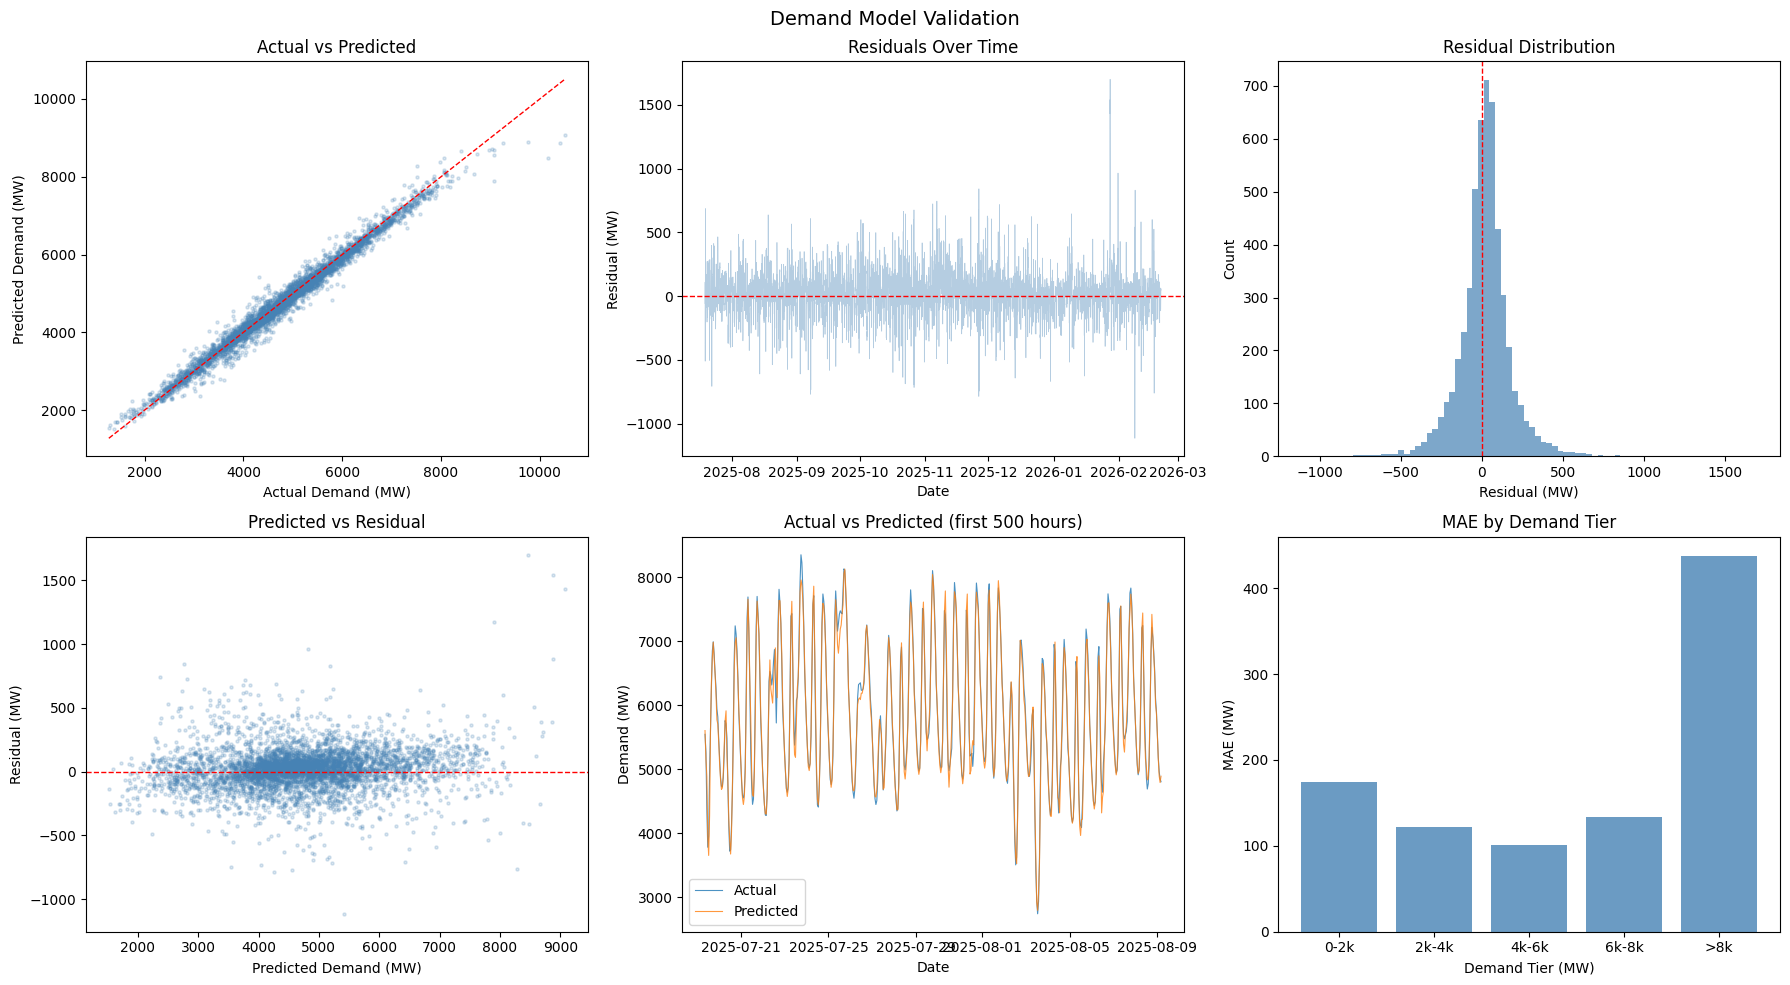

In [0]:
test_dates = f['datetime_aest'].iloc[split_idx:].values

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Demand Model Validation', fontsize=14)


ax = axes[0, 0]
ax.scatter(y_test, y_pred, alpha=0.2, s=5, color='steelblue')
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
ax.plot(lims, lims, 'r--', linewidth=1)
ax.set_xlabel('Actual Demand (MW)')
ax.set_ylabel('Predicted Demand (MW)')
ax.set_title('Actual vs Predicted')


ax = axes[0, 1]
ax.plot(test_dates, residuals, alpha=0.4, linewidth=0.5, color='steelblue')
ax.axhline(0, color='red', linestyle='--', linewidth=1)
ax.set_xlabel('Date')
ax.set_ylabel('Residual (MW)')
ax.set_title('Residuals Over Time')


ax = axes[0, 2]
ax.hist(residuals, bins=80, color='steelblue', alpha=0.7, edgecolor='none')
ax.axvline(0, color='red', linestyle='--', linewidth=1)
ax.set_xlabel('Residual (MW)')
ax.set_ylabel('Count')
ax.set_title('Residual Distribution')


ax = axes[1, 0]
ax.scatter(y_pred, residuals, alpha=0.2, s=5, color='steelblue')
ax.axhline(0, color='red', linestyle='--', linewidth=1)
ax.set_xlabel('Predicted Demand (MW)')
ax.set_ylabel('Residual (MW)')
ax.set_title('Predicted vs Residual')


ax = axes[1, 1]
n = min(500, len(test_dates))
ax.plot(test_dates[:n], y_test.values[:n], label='Actual',    linewidth=0.8, alpha=0.8)
ax.plot(test_dates[:n], y_pred[:n],        label='Predicted', linewidth=0.8, alpha=0.8)
ax.set_xlabel('Date')
ax.set_ylabel('Demand (MW)')
ax.set_title('Actual vs Predicted (first 500 hours)')
ax.legend()


ax = axes[1, 2]
bins   = [0, 2000, 4000, 6000, 8000, 11000]
labels = ['0-2k', '2k-4k', '4k-6k', '6k-8k', '>8k']
tiers  = pd.cut(y_test, bins=bins, labels=labels)
mae_by_tier = pd.DataFrame({'residual': np.abs(residuals), 'tier': tiers}) \
                .groupby('tier')['residual'].mean()
ax.bar(mae_by_tier.index, mae_by_tier.values, color='steelblue', alpha=0.8)
ax.set_xlabel('Demand Tier (MW)')
ax.set_ylabel('MAE (MW)')
ax.set_title('MAE by Demand Tier')

plt.tight_layout()
plt.show()

In [0]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)
fold_results = []

for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
    X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
    y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]

    m = CatBoostRegressor(
        n_estimators=8192, learning_rate=0.0413,
        depth=6, l2_leaf_reg=5.0,
        early_stopping_rounds=21, random_seed=42, verbose=0
    )
    m.fit(X_tr, y_tr, eval_set=(X_te, y_te))
    
    mae = mean_absolute_error(y_te, m.predict(X_te))
    r2  = r2_score(y_te, m.predict(X_te))
    fold_results.append({'fold': fold+1, 'mae': mae, 'r2': r2})
    print(f"Fold {fold+1} | MAE {mae:.0f} MW | R² {r2:.4f}")

results_df = pd.DataFrame(fold_results)
print(f"\nMean MAE : {results_df['mae'].mean():.0f} MW")
print(f"Std  MAE : {results_df['mae'].std():.0f} MW")

Fold 1 | MAE 0 MW | R² 0.2666
Fold 2 | MAE 0 MW | R² 0.5967
Fold 3 | MAE 0 MW | R² 0.3413
Fold 4 | MAE 0 MW | R² 0.6533
Fold 5 | MAE 0 MW | R² 0.4323

Mean MAE : 0 MW
Std  MAE : 0 MW


#Price Spike prediction

In [0]:


spark.sql("USE energy_analytics")

df = spark.table("silver_energy_melbourne_extended") \
    .filter(col("avg_temp").isNotNull()) \
    .select(
        col("datetime_aest"),
        col("hour_of_day"),
        col("day_of_week"),
        col("month"),
        col("price"),
        col("price_max"),
        col("price_min"),
        col("demand_mw"),
        col("renewable_pct"),
        col("coal"),
        col("gas"),
        col("wind"),
        col("solar"),
        col("total_generation"),
        col("semischeduled_generation"),
        col("avg_temp"),
        col("avg_humidity"),
        col("avg_wind_speed"),
        col("solar_radiation"),
        col("cloud_cover"),
        when(col("is_peak") == 1.0, 1.0).otherwise(0.0).alias("is_peak")
    ) \
    .orderBy("datetime_aest")

df = df.toPandas().sort_values("datetime_aest").reset_index(drop=True)

SPIKE_THRESHOLD = 200
df['is_spike'] = (df['price'] > SPIKE_THRESHOLD).astype(int)

print(f"Records      : {len(df):,}")
print(f"Spikes >$200 : {df['is_spike'].sum():,} ({df['is_spike'].mean()*100:.1f}%)")

Records      : 26,160
Spikes >$200 : 1,724 (6.6%)


In [0]:


f = df.copy()

# Cyclical time
f['hour_sin']  = np.sin(2 * np.pi * f['hour_of_day'] / 24)
f['hour_cos']  = np.cos(2 * np.pi * f['hour_of_day'] / 24)
f['dow_sin']   = np.sin(2 * np.pi * f['day_of_week'] / 7)
f['dow_cos']   = np.cos(2 * np.pi * f['day_of_week'] / 7)
f['month_sin'] = np.sin(2 * np.pi * f['month'] / 12)
f['month_cos'] = np.cos(2 * np.pi * f['month'] / 12)

f['price_range'] = f['price_max'] - f['price_min']

# Lags
for col_name, shifts in [
    ('price',          [1, 2, 3, 24]),
    ('demand_mw',      [1, 24]),
    ('renewable_pct',  [1, 24]),
    ('avg_temp',       [1, 24]),
    ('solar_radiation',[1, 24]),
    ('wind',           [1]),
    ('coal',           [1]),
    ('gas',            [1]),
]:
    for s in shifts:
        f[f'{col_name}_lag{s}'] = f[col_name].shift(s)

# Rolling stats
for window in [4, 24]:
    f[f'price_roll{window}_mean'] = f['price'].shift(1).rolling(window).mean()
    f[f'price_roll{window}_std']  = f['price'].shift(1).rolling(window).std()
    f[f'demand_roll{window}_mean']= f['demand_mw'].shift(1).rolling(window).mean()

# Spike history
f['spike_lag1']       = f['is_spike'].shift(1)
f['spike_lag2']       = f['is_spike'].shift(2)
f['spike_roll4_sum']  = f['is_spike'].shift(1).rolling(4).sum()
f['spike_roll24_sum'] = f['is_spike'].shift(1).rolling(24).sum()

# Interactions
f['temp_x_demand']      = f['avg_temp']      * f['demand_mw']
f['renewable_x_demand'] = f['renewable_pct'] * f['demand_mw']
f['temp_x_peak']        = f['avg_temp']      * f['is_peak']
f['demand_dev24']       = f['demand_mw']     - f['demand_roll24_mean']
f['price_momentum']     = f['price_lag1']    - f['price_lag24']

# Physical stress features
f['season'] = f['month'].map({12:0, 1:0, 2:0,
                               3:1, 4:1, 5:1,
                               6:2, 7:2, 8:2,
                               9:3, 10:3, 11:3})

f['summer_heatwave']      = ((f['season'] == 0) & (f['avg_temp'] > 25)).astype(float)
f['summer_low_renewable'] = ((f['season'] == 0) & (f['renewable_pct_lag1'] < 30)).astype(float)
f['summer_stress']        = ((f['season'] == 0) & (f['avg_temp'] > 25) & (f['renewable_pct_lag1'] < 30)).astype(float)
f['winter_low_wind']      = ((f['season'] == 2) & (f['wind_lag1'] < f['wind'].quantile(0.25))).astype(float)
f['high_pressure_proxy']  = ((f['avg_wind_speed'] < 10) & (f['avg_temp'] > 20)).astype(float)
f['supply_squeeze']       = f['total_generation'] / f['demand_mw']
f['heat_x_low_wind']      = f['avg_temp'] * (1 / (f['wind_lag1'] + 1))
f['heat_x_low_solar']     = f['avg_temp'] * (1 / (f['solar_radiation_lag1'] + 1))
f['demand_supply_gap']    = f['demand_mw_lag1'] - f['total_generation']
f['low_renewable_stress'] = ((f['renewable_pct_lag1'] < 15) & (f['demand_mw_lag1'] > 7000)).astype(float)

# Net load
f['net_load']        = f['demand_mw'] - (f['wind'] + f['solar'])
f['net_load_lag1']   = f['net_load'].shift(1)
f['net_load_roll4']  = f['net_load'].shift(1).rolling(4).mean()
f['net_load_stress'] = (f['net_load'] > f['net_load'].quantile(0.90)).astype(float)

f = f.dropna().reset_index(drop=True)

features = [
    'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'month_sin', 'month_cos',
    'season',
    'demand_mw', 'renewable_pct', 'avg_temp', 'avg_humidity', 'avg_wind_speed',
    'solar_radiation', 'cloud_cover', 'is_peak',
    'coal', 'gas', 'wind', 'solar', 'total_generation', 'semischeduled_generation',
    'price_range',
    'price_lag1', 'price_lag2', 'price_lag3', 'price_lag24',
    'demand_mw_lag1', 'demand_mw_lag24',
    'renewable_pct_lag1', 'renewable_pct_lag24',
    'avg_temp_lag1', 'avg_temp_lag24',
    'solar_radiation_lag1', 'solar_radiation_lag24',
    'wind_lag1', 'coal_lag1', 'gas_lag1',
    'price_roll4_mean', 'price_roll4_std',
    'price_roll24_mean', 'price_roll24_std',
    'demand_roll4_mean', 'demand_roll24_mean',
    'spike_lag1', 'spike_lag2',
    'spike_roll4_sum', 'spike_roll24_sum',
    'temp_x_demand', 'renewable_x_demand', 'temp_x_peak',
    'demand_dev24', 'price_momentum',
    'summer_heatwave', 'summer_low_renewable', 'summer_stress',
    'winter_low_wind', 'high_pressure_proxy',
    'supply_squeeze', 'heat_x_low_wind', 'heat_x_low_solar',
    'demand_supply_gap', 'low_renewable_stress',
    'net_load', 'net_load_lag1', 'net_load_roll4', 'net_load_stress',
]

X = f[features]
y = f['is_spike']

f_spike = f.copy()
X_spike = f[features]
f_spike = f.copy()
X_spike = f[features]
y_spike = f['is_spike']

print(f"Features : {len(features)}")
print(f"Samples  : {len(X):,}")
print(f"Spikes   : {y.sum():,} ({y.mean()*100:.1f}%)")

Features : 66
Samples  : 26,112
Spikes   : 1,723 (6.6%)


In [0]:
split_idx = int(len(X_spike) * 0.8)
X_train, X_test = X_spike.iloc[:split_idx], X_spike.iloc[split_idx:]
y_train, y_test = y_spike.iloc[:split_idx], y_spike.iloc[split_idx:]

spike_ratio   = float((y_train == 0).sum() / (y_train == 1).sum())
sample_weight = np.where(y_train == 1, spike_ratio, 1.0)

model_spike = XGBClassifier(
    n_estimators=670,
    max_depth=10,
    min_child_weight=13.946,
    learning_rate=0.0293,
    subsample=0.841,
    colsample_bylevel=0.549,
    colsample_bytree=0.711,
    reg_alpha=0.00311,
    reg_lambda=1.706,
    scale_pos_weight=spike_ratio,
    tree_method="hist",
    random_state=42,
    n_jobs=-1
)

model_spike.fit(X_train, y_train, sample_weight=sample_weight)

platt = CalibratedClassifierCV(model_spike, method='sigmoid', cv='prefit')
platt.fit(X_train, y_train)

y_proba = platt.predict_proba(X_test)[:, 1]
y_pred  = (y_proba >= 0.7).astype(int)

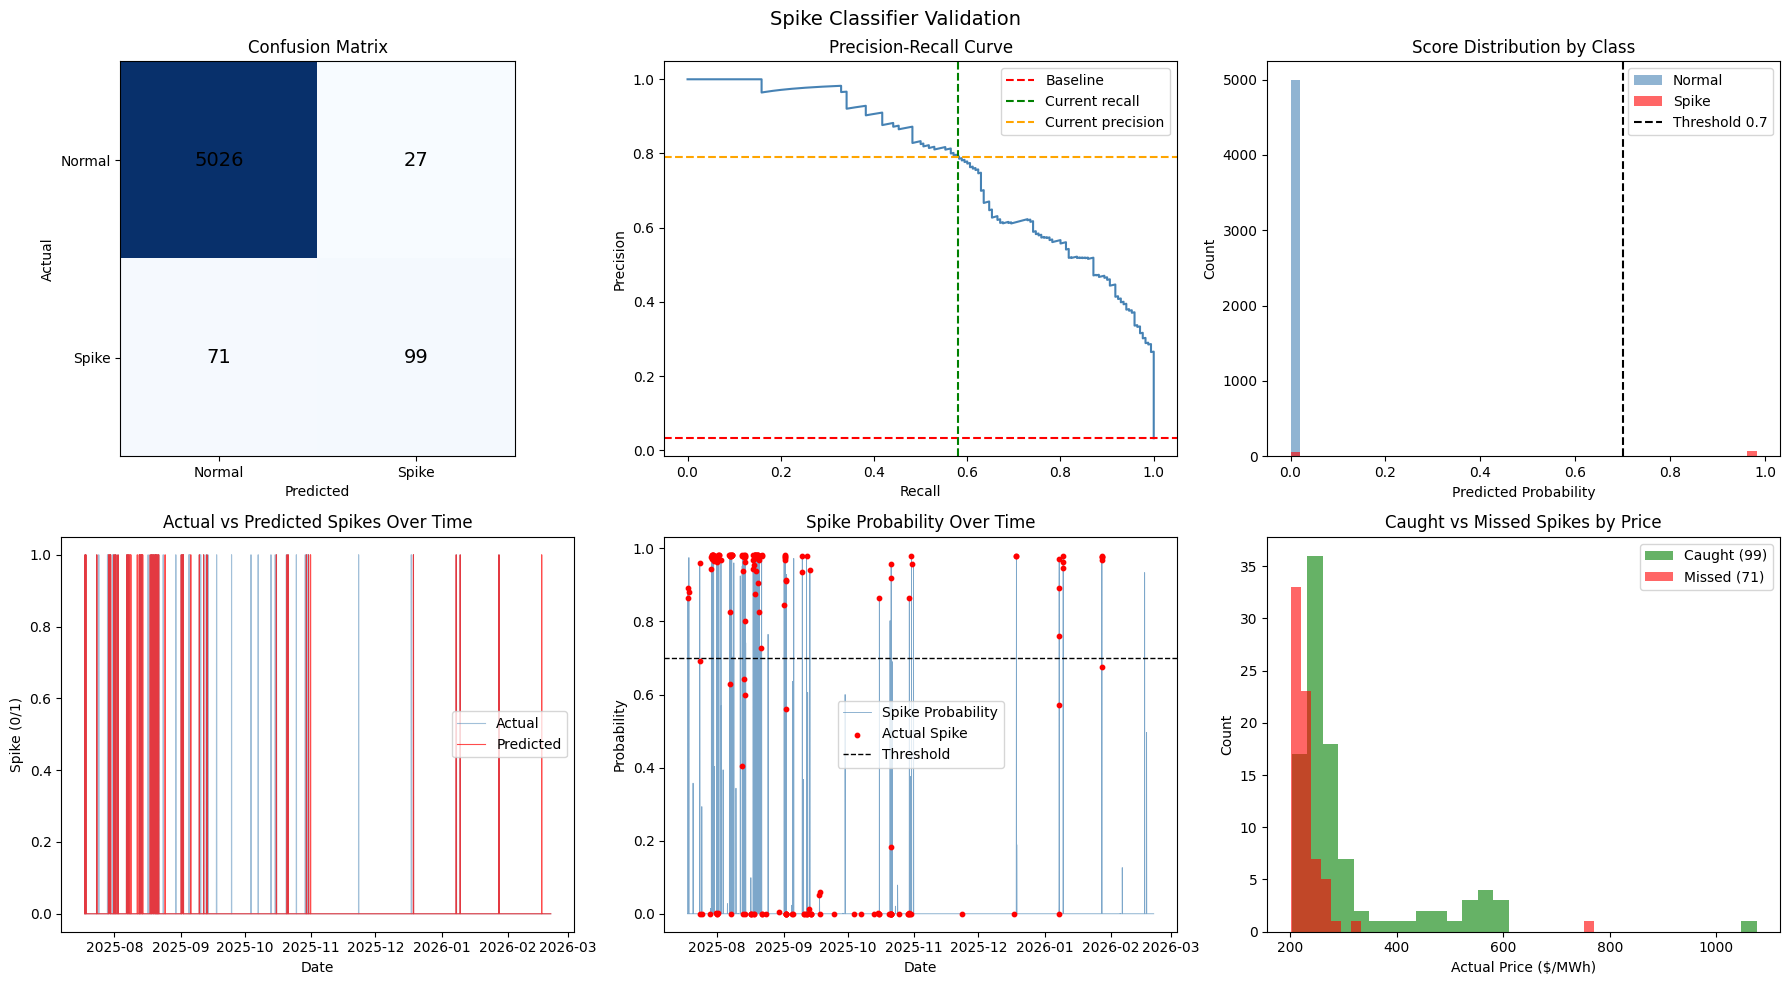

Caught spikes — avg price: $308/MWh
Missed spikes — avg price: $233/MWh


In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, precision_recall_curve

test_dates = f['datetime_aest'].iloc[split_idx:].values
residuals  = y_test.values - y_pred

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Spike Classifier Validation', fontsize=14)

cm = confusion_matrix(y_test, y_pred)
ax = axes[0, 0]
ax.imshow(cm, cmap='Blues')
ax.set_xticks([0, 1]); ax.set_yticks([0, 1])
ax.set_xticklabels(['Normal', 'Spike'])
ax.set_yticklabels(['Normal', 'Spike'])
ax.set_xlabel('Predicted'); ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', fontsize=14)


p_curve, r_curve, thresholds_curve = precision_recall_curve(y_test, y_proba)
ax = axes[0, 1]
ax.plot(r_curve, p_curve, color='steelblue', linewidth=1.5)
ax.axhline(y_test.mean(), color='red', linestyle='--', label='Baseline')
ax.axvline(0.58, color='green', linestyle='--', label='Current recall')
ax.axhline(0.79, color='orange', linestyle='--', label='Current precision')
ax.set_xlabel('Recall'); ax.set_ylabel('Precision')
ax.set_title('Precision-Recall Curve')
ax.legend()


ax = axes[0, 2]
ax.hist(y_proba[y_test == 0], bins=50, alpha=0.6, color='steelblue', label='Normal')
ax.hist(y_proba[y_test == 1], bins=50, alpha=0.6, color='red',       label='Spike')
ax.axvline(0.7, color='black', linestyle='--', label='Threshold 0.7')
ax.set_xlabel('Predicted Probability')
ax.set_ylabel('Count')
ax.set_title('Score Distribution by Class')
ax.legend()

ax = axes[1, 0]
ax.plot(test_dates, y_test.values,  alpha=0.5, linewidth=0.8, color='steelblue', label='Actual')
ax.plot(test_dates, y_pred,         alpha=0.7, linewidth=0.8, color='red',       label='Predicted')
ax.set_xlabel('Date'); ax.set_ylabel('Spike (0/1)')
ax.set_title('Actual vs Predicted Spikes Over Time')
ax.legend()


ax = axes[1, 1]
ax.plot(test_dates, y_proba, linewidth=0.6, color='steelblue', alpha=0.7, label='Spike Probability')
ax.scatter(test_dates[y_test.values == 1], y_proba[y_test.values == 1],
           color='red', s=10, zorder=5, label='Actual Spike')
ax.axhline(0.7, color='black', linestyle='--', linewidth=1, label='Threshold')
ax.set_xlabel('Date'); ax.set_ylabel('Probability')
ax.set_title('Spike Probability Over Time')
ax.legend()


missed_mask  = (y_test.values == 1) & (y_pred == 0)
caught_mask  = (y_test.values == 1) & (y_pred == 1)
actual_price = f['price'].iloc[split_idx:].values

ax = axes[1, 2]
ax.hist(actual_price[caught_mask], bins=30, alpha=0.6, color='green', label=f'Caught ({caught_mask.sum()})')
ax.hist(actual_price[missed_mask], bins=30, alpha=0.6, color='red',   label=f'Missed ({missed_mask.sum()})')
ax.set_xlabel('Actual Price ($/MWh)')
ax.set_ylabel('Count')
ax.set_title('Caught vs Missed Spikes by Price')
ax.legend()

plt.tight_layout()
plt.show()

print(f"Caught spikes — avg price: ${actual_price[caught_mask].mean():.0f}/MWh")
print(f"Missed spikes — avg price: ${actual_price[missed_mask].mean():.0f}/MWh")

In [0]:



PRICE_SHIFT = 462.5025


price_log   = model_price.predict(X_price)
demand_pred = model_demand.predict(X_demand)
spike_prob  = platt.predict_proba(X_spike)[:, 1]


price_df = pd.DataFrame({
    'datetime_aest'   : f_price['datetime_aest'].values,
    'actual_price'    : f_price['price'].values,
    'predicted_price' : np.expm1(price_log) - PRICE_SHIFT,
    'avg_temp'        : f_price['avg_temp'].values,
    'renewable_pct'   : f_price['renewable_pct'].values,
    'is_peak'         : f_price['is_peak'].values,
})

demand_df = pd.DataFrame({
    'datetime_aest'    : f_demand['datetime_aest'].values,
    'actual_demand'    : f_demand['demand_mw'].values,
    'predicted_demand' : demand_pred,
})

spike_df = pd.DataFrame({
    'datetime_aest'    : f_spike['datetime_aest'].values,
    'actual_spike'     : f_spike['is_spike'].values,
    'spike_probability': spike_prob,
    'spike_alert'      : (spike_prob >= 0.7).astype(int),
    'spike_alert_label': np.where(spike_prob >= 0.7, 'SPIKE RISK', 'NORMAL'),
    'season'           : f_spike['season'].values,
})


gold_df = price_df \
    .merge(demand_df, on='datetime_aest', how='inner') \
    .merge(spike_df,  on='datetime_aest', how='inner')


gold_df['price_error']  = gold_df['predicted_price']  - gold_df['actual_price']
gold_df['demand_error'] = gold_df['predicted_demand'] - gold_df['actual_demand']

print(f"Rows    : {len(gold_df):,}")
print(f"Columns : {len(gold_df.columns)}")
print(f"From    : {gold_df['datetime_aest'].min()}")
print(f"To      : {gold_df['datetime_aest'].max()}")
print(gold_df.head())


spark.createDataFrame(gold_df) \
     .write.mode("overwrite") \
     .saveAsTable("energy_analytics.gold_predictions")

print("\nSaved to energy_analytics.gold_predictions ✅")

Rows    : 26,256
Columns : 15
From    : 2023-03-08 00:00:00
To      : 2026-02-20 23:00:00
        datetime_aest  actual_price  ...  price_error  demand_error
0 2023-03-08 00:00:00      6.871667  ...     0.182258     29.106330
1 2023-03-08 01:00:00      7.484167  ...    -0.299627     50.825325
2 2023-03-08 02:00:00     35.230833  ...   -16.252013    -91.247304
3 2023-03-08 03:00:00     71.511667  ...   -14.602548    -64.418717
4 2023-03-08 04:00:00     68.102500  ...     2.574624     22.930297

[5 rows x 15 columns]

Saved to energy_analytics.gold_predictions ✅
